In [1]:
library(Seurat)
library(data.table)
library(ggplot2)
library(flexclust)

Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3
Loading required package: grid
Loading required package: lattice
Loading required package: modeltools
Loading required package: stats4


# analysis

In [2]:
datasetName="/stor/public/hcad/lung_lung_HCLAdultLung3/lung_lung_HCLAdultLung3"

In [3]:
# scRNA
raw_data <- read.csv(paste0(datasetName, "_expression.tsv.gz"),header = TRUE, sep='\t',row.names = 1)

In [4]:
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv.gz"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv.gz"), h = T, sep = "\t", row.names = 1)

In [5]:
# build object
dataobj <- CreateSeuratObject(counts = raw_data, project = "HCAd",meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”

In [6]:
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))

Centering and scaling data matrix


In [7]:
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))

PC_ 1 
Positive:  C1QB, C1QA, CTSD, APOC1, S100A4, S100A11, MARCO, FN1, LYZ, S100A10 
	   CTSB, CD52, FCGR3A, C1QC, FABP4, ACP5, CTSC, GPNMB, HLA-C, MCEMP1 
	   LGALS3, MRC1, MSR1, VSIG4, ALDH2, CCL18, ALOX5AP, FTLP3, SERPING1, CSTB 
Negative:  SFTPB, SFTPC, SFTPA1, SFTPA2, NAPSA, SLPI, SLC34A2, MUC1, SFTPD, SCGB3A2 
	   SFTA2, LAMP3, STEAP4, RNASE1, CXCL17, ABCA3, LPCAT1, DHCR24, SELENBP1, C8orf4 
	   SDC4, PIGR, C16orf89, C3, AGR3, C11orf96, CLDN18, PGC, ELF3, AQP1 
PC_ 2 
Positive:  CDKN1A, RGS1, GPR183, G0S2, IER3, BIRC3, IL1B, CREM, RGS2, TNFAIP3 
	   SPARCL1, RPS27, CCL3, CCL5, CCL4, FCN1, BCL2A1, CXCL8, CCL3L3, DUSP2 
	   NFKBIA, TIMP1, DDIT4, PPP1R15A, EREG, TNFAIP8, MGP, CCL4L2, SERPINB9, IGFBP7 
Negative:  C1QB, CTSD, C1QA, SCD, APOC1, MT-ND3, FN1, MARCO, SFTPB, FBP1 
	   FABP4, SFTPC, SFTPA1, SFTPA2, SERPING1, ALDH2, NAPSA, MT-CO2, SLC34A2, NUPR1 
	   SFTPD, MSR1, MT-CO3, MUC1, ACP5, LTA4H, C1QC, SLPI, MCEMP1, MT-ATP6 
PC_ 3 
Positive:  GPR183, IL1B, G0S2, BCL2A1, RGS1, CXCL

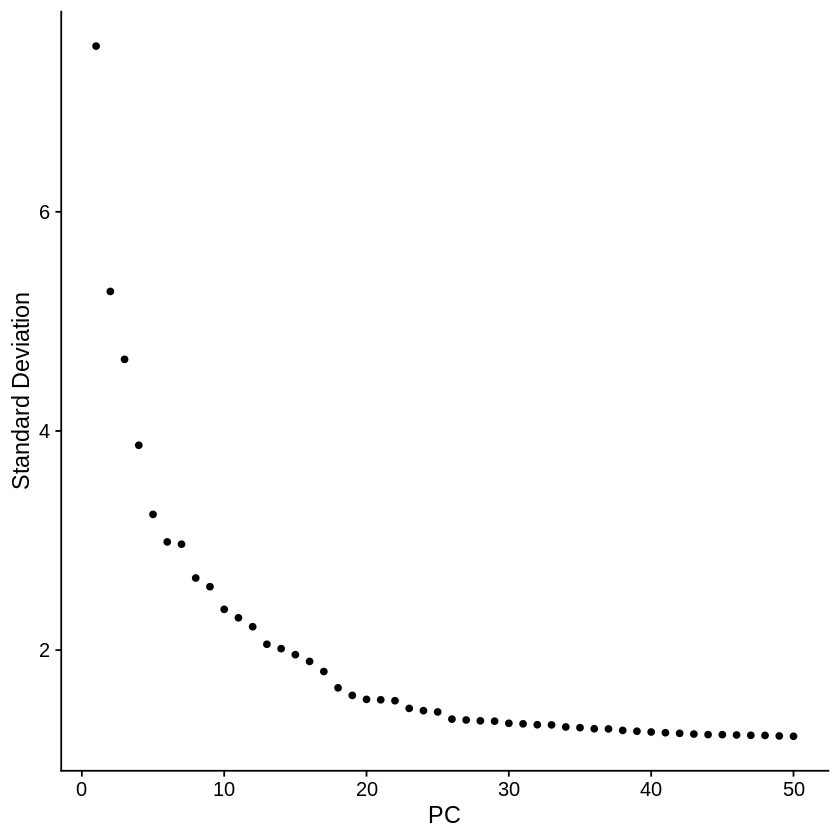

In [8]:
ElbowPlot(dataobj,50) 

In [11]:
pcDim = 30
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”19:36:59 UMAP embedding parameters a = 0.9922 b = 1.112
19:36:59 Read 9603 rows and found 30 numeric columns
19:36:59 Using Annoy for neighbor search, n_neighbors = 30
19:36:59 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
19:37:01 Writing NN index file to temp file /tmp/RtmpGTFAYw/file6ce562381dbb
19:37:01 Searching Annoy index using 1 thread, search_k = 3000
19:37:04 Annoy recall = 100%
19:37:04 Commencing smooth kNN distance calibration using 1 thread
19:37:05 Initializing from normalized Laplacian + noise
19:37:06 Commencing optimizatio

In [6]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1) + NoLegend()
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”

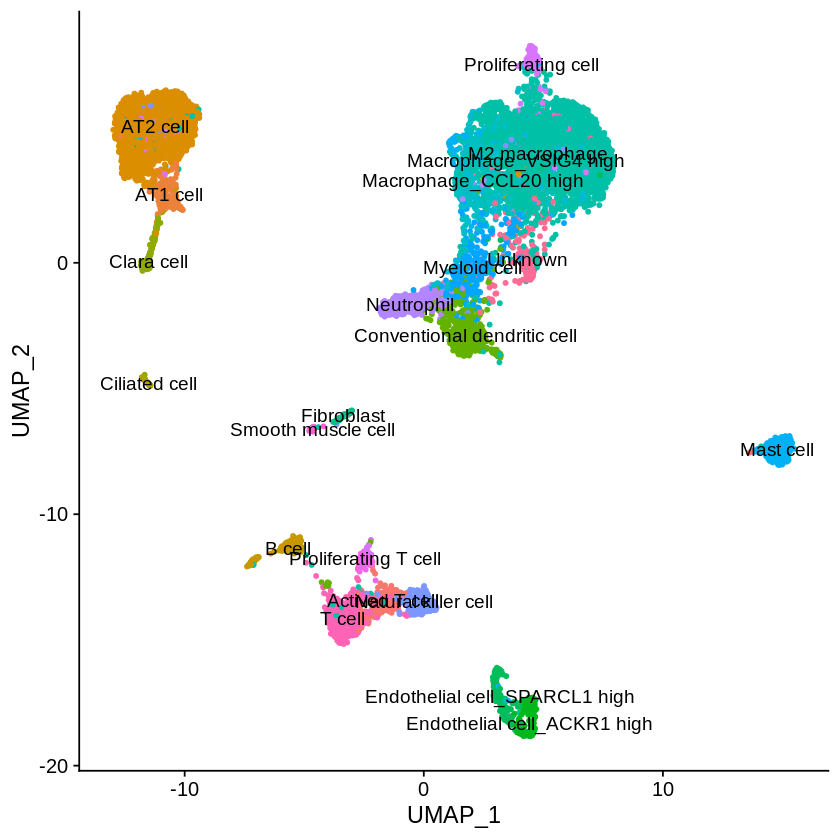

In [7]:
p_umap2

# Clustering

In [10]:
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:30, nn.eps = 0.5)

Computing nearest neighbor graph
Computing SNN


In [11]:
dataobj <- FindClusters(dataobj, resolution = 2, n.start = 20)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9603
Number of edges: 377884

Running Louvain algorithm...
Maximum modularity in 20 random starts: 0.7805
Number of communities: 31
Elapsed time: 2 seconds


In [8]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE, pt.size=1)
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

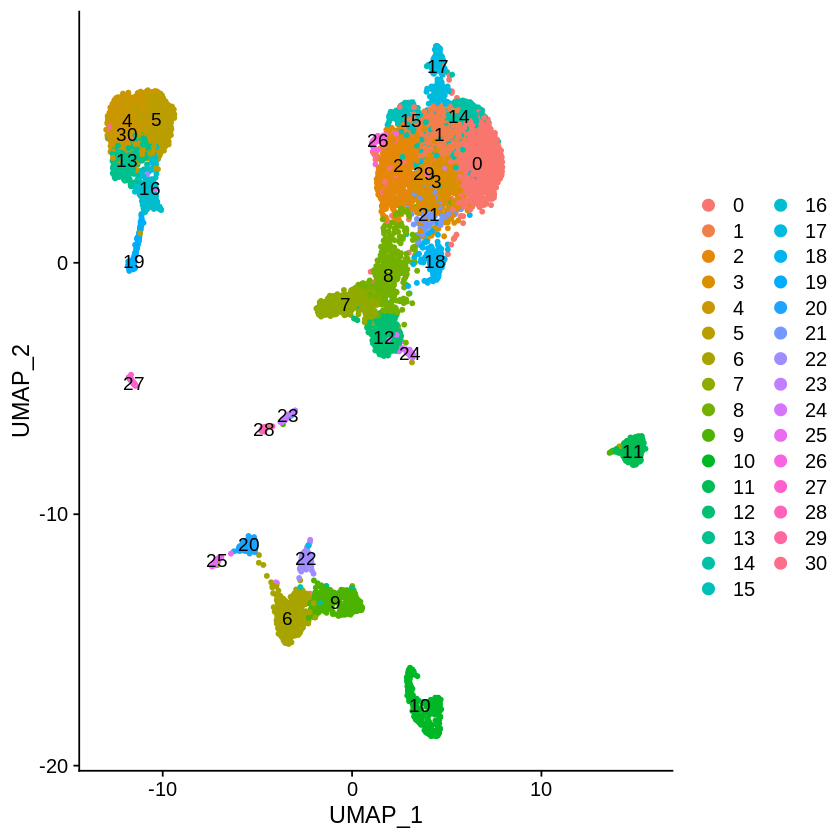

In [9]:
p_umap

# Finding cluster markers 

In [24]:
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6
Calculating cluster 7
Calculating cluster 8
Calculating cluster 9
Calculating cluster 10
Calculating cluster 11
Calculating cluster 12
Calculating cluster 13
Calculating cluster 14
Calculating cluster 15
Calculating cluster 16
Calculating cluster 17
Calculating cluster 18
Calculating cluster 19
Calculating cluster 20
Calculating cluster 21
Calculating cluster 22
Calculating cluster 23
Calculating cluster 24
Calculating cluster 25
Calculating cluster 26
Calculating cluster 27
Calculating cluster 28
Calculating cluster 29
Calculating cluster 30


# Annotation

In [3]:
dataobj <- readRDS(paste0(datasetName,".seuratobj.rds"))

In [5]:
dataobj.markers <- read.table(paste0(datasetName,".seurat.markers.txt"), sep = "\t", h = T)


In [119]:
dataobj.markers[dataobj.markers['cluster']==30,]

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
6000,2.205587e-41,1.586252,0.444,0.009,5.584987e-37,30,CALB2
6001,2.257281e-37,1.319156,0.333,0.006,5.715887e-33,30,SMIM1
6002,1.727682e-35,1.553363,0.444,0.011,4.374836e-31,30,IL1RL1
6003,9.066919e-34,1.963218,1.000,0.055,2.295925e-29,30,CPA3
6004,1.020080e-31,1.795481,0.556,0.018,2.583047e-27,30,SLC18A2
6005,5.875356e-30,2.010103,1.000,0.063,1.487758e-25,30,TPSAB1
6006,2.027244e-23,1.174937,0.333,0.009,5.133386e-19,30,SCIN
6007,2.085202e-20,1.154411,0.333,0.011,5.280150e-16,30,RAB17
6008,1.011093e-19,2.082579,1.000,0.104,2.560289e-15,30,TPSB2


In [122]:
dataobj.markers[dataobj.markers['gene']=='PDPN',]

p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>


In [12]:
new.cluster.ids <- c('Lung-Connective Tissue-Macrophage-S100A8 FCGR3A',#0
                     'Lung-Connective Tissue-Macrophage-S100A8 FCGR3A',
                     'Lung-Connective Tissue-Macrophage-FCGR3A FABP4',
                     'Lung-Connective Tissue-Macrophage-S100A8 CD14',
                     'Lung-Epithelial Tissue-Type II alveolar cell-SFTPC SFTPD',
                     'Lung-Epithelial Tissue-Type II alveolar cell-SFTPC SFTPD',#5
                     'Lung-Connective Tissue-T cell-CD3D TRAC',
                     'Lung-Connective Tissue-Neutrophilic granulocyte-S100A8 S100A9',
                     'Lung-Connective Tissue-Myeloid cell-S100A8 CD14',# Myeloid cell
                     'Lung-Connective Tissue-CD8 T cell-GZMB GZMH',
                     'Lung-Epithelial Tissue-Endothelial cell-ACKR1 POSTN',#10
                     'Lung-Connective Tissue-Mast cell-TPSAB1 CPA3',
                     'Lung-Connective Tissue-Dendritic cell-CD1C HLA-DRA',
                     'Lung-Epithelial Tissue-Type II alveolar cell-SFTPC SFTPD',
                     'Lung-Connective Tissue-Macrophage-FCGR3A FABP4',
                     'Lung-Connective Tissue-Macrophage-FCGR3A FABP4',#15
                     'Lung-Epithelial Tissue-Type I alveolar cell-AGER SFTPC',
                     'Lung-Connective Tissue-Macrophage-FCGR3A FABP4',
                     'Lung-Connective Tissue-Macrophage-CD14',
                     'Lung-Epithelial Tissue-Club cell-SCGB3A1 SCGB1A1',
                     'Lung-Connective Tissue-Plasma cell-CD79A CD27',#20
                     'Lung-Connective Tissue-Macrophage-S100A8 FCGR3A',
                     'Lung-Connective Tissue-T cell-CD3D TRAC',
                     'Lung-Connective Tissue-Fibrocyte-DCN LUM',
                     'Lung-Connective Tissue-Dendritic cell-LGALS2 HLA-DRA',
                     'Lung-Connective Tissue-Plasma cell-CD79A CD27',#25
                     'Lung-Connective Tissue-Mast cell-TPSAB1 CPA3',
                     'Lung-Epithelial Tissue-Ciliated columnar cell-FOXJ1 CCDC78',
                     'Lung-Musle Tissue-Smooth muscle cell-ACTA2 MYL9',
                     'Lung-Epithelial Tissue-Type II alveolar cell-SFTPC SFTPD',
                     'Lung-Connective Tissue-Mast cell-TPSAB1 CPA3'#30
                    
                    )

In [5]:
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)
plot <- DimPlot(dataobj, reduction = "umap",label = TRUE, pt.size = 1) + NoLegend()

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”

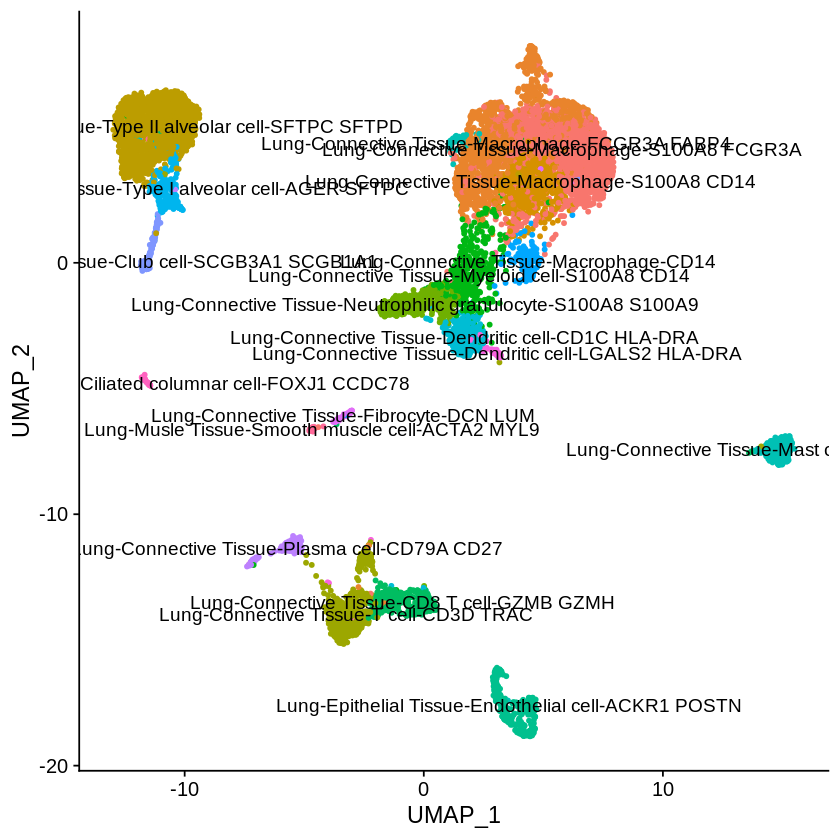

In [135]:
plot

In [42]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = plot, width = 8, height = 5)

In [3]:
dataobj <- readRDS(paste0(datasetName,".seuratobj.rds"))

In [13]:
dataobj@meta.data$hcad.label <- Idents(dataobj)

In [14]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [13]:
df_hca <- data.frame(rownames(dataobj@meta.data),dataobj@meta.data$hcad.label)
colnames(df_hca) <- c('cell_ID', 'cell_cluster')

In [14]:
write.table(df_hca, file = paste0(datasetName,"_annotation.hcad.tsv"), sep = "\t", quote = F, row.names = F, col.names = T)

# update annotation


In [78]:
dataobj <- readRDS("/stor/public/hcad/db_v1/lung_lung_HCLAdultLung2/lung_lung_HCLAdultLung2.seuratobj.dbupload_v1.rds")

In [79]:
dataobj

An object of class Seurat 
43878 features across 6022 samples within 1 assay 
Active assay: RNA (43878 features, 0 variable features)

In [80]:
table(dataobj$original_name[dataobj$hcad_name == "Lung-Connective tissue-NK cell-TOP2A CDK1"])


                                       AT1 cell 
                                              6 
                                       AT2 cell 
                                             12 
                                     Clara cell 
                                              3 
                                 Dendritic cell 
                                              1 
                  Endothelial cell_TMEM100 high 
                                              1 
                   Epithelial cell_PLA2G2A high 
                                              1 
                                     Fibroblast 
                                             19 
                                     Neutrophil 
                                              2 
Proliferating alveolar bipotent progenitor cell 
                                             99 
                             Proliferating cell 
                                             23 
                   

In [81]:
dataobj$cell_type[dataobj$hcad_name == "Lung-Connective tissue-NK cell-TOP2A CDK1"] <- "Type II alveolar cell"
dataobj$tissue_type[dataobj$hcad_name == "Lung-Connective tissue-NK cell-TOP2A CDK1"] <- "Epithelial tissue"
dataobj$marker_gene[dataobj$hcad_name == "Lung-Connective tissue-NK cell-TOP2A CDK1"] <- "SFTPC SFTPD"
dataobj$hcad_name[dataobj$hcad_name == "Lung-Connective tissue-NK cell-TOP2A CDK1"] <- 'Lung-Epithelial tissue-Type II alveolar cell-SFTPC SFTPD'

In [82]:
saveRDS(dataobj, "/stor/public/hcad/db_v1.1/lung_lung_HCLAdultLung2/lung_lung_HCLAdultLung2.seuratobj.dbupload_v1.rds")